| Version | Date       | Developer | Remark             |
|---------|------------|-----------|--------------------|
| 1.0     | Feb-1-2025 | Johnson | Initial version: build models with sklearn & MLlib    |

**Context**

The insurance.csv dataset contains 1338 observations (rows) and 7 features (columns). The dataset contains 4 numerical features (age, bmi, children and expenses) and 3 nominal features (sex, smoker and region) that were converted into factors with numerical value designated for each level.

**Data source**: [Kaggle](https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction?select=insurance.csv)

# 1. Exploratory Data Analysis

In [0]:
%run ./Common_Function

In [0]:
data = '/Workspace/Users/hejiekun@hotmail.com/insurance.csv'
df = pd.read_csv(data)
df_sp = spark.createDataFrame(df)
display(df_sp.limit(10))

age,sex,bmi,children,smoker,region,expenses
19,female,27.9,0,yes,southwest,16884.92
18,male,33.8,1,no,southeast,1725.55
28,male,33.0,3,no,southeast,4449.46
33,male,22.7,0,no,northwest,21984.47
32,male,28.9,0,no,northwest,3866.86
31,female,25.7,0,no,southeast,3756.62
46,female,33.4,1,no,southeast,8240.59
37,female,27.7,3,no,northwest,7281.51
37,male,29.8,2,no,northeast,6406.41
60,female,25.8,0,no,northwest,28923.14


In [0]:
num_rows = df_sp.count()  
num_cols = len(df_sp.columns)   
print(f'{num_rows} Records,{num_cols} Features.')

1338 Records,7 Features.


In [0]:
df_sp.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: long (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



In [0]:
df_pd = df_sp.toPandas()  

print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


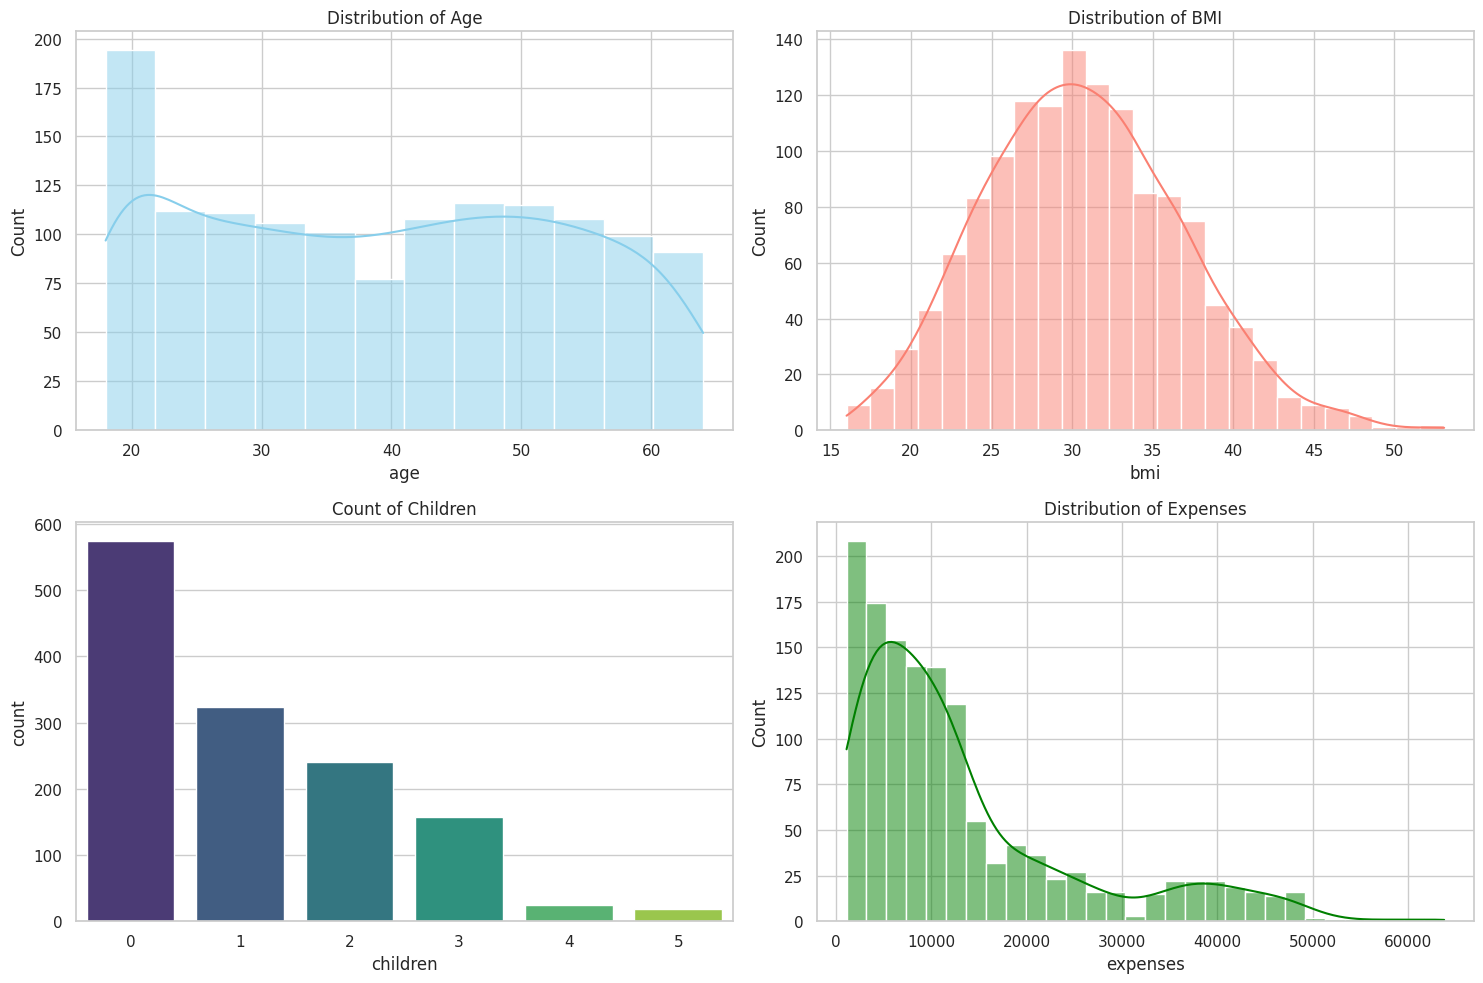

In [0]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of 'age'
sns.histplot(df_pd['age'], kde=True, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title('Distribution of Age')
# Distribution of 'bmi'
sns.histplot(df_pd['bmi'], kde=True, ax=axes[0, 1], color="salmon")
axes[0, 1].set_title('Distribution of BMI')
# Distribution of 'children'
sns.countplot(x='children', data=df_pd, palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Count of Children')
# Distribution of 'expenses'
sns.histplot(df['expenses'], kde=True, ax=axes[1, 1], color="green")
axes[1, 1].set_title('Distribution of Expenses')

plt.tight_layout()
plt.show()

# Pairplot to see relationships and scatter patterns
# sns.pairplot(df, hue="smoker", palette="coolwarm")
# plt.show()

expenses            1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198576
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: expenses, dtype: float64


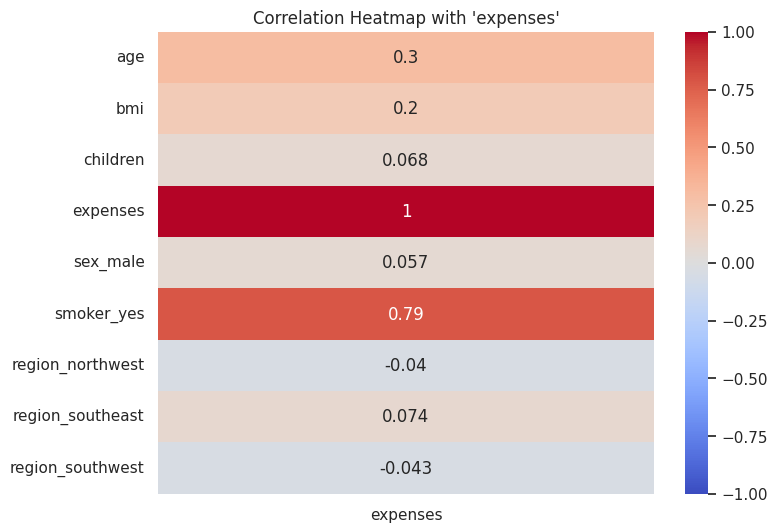

In [0]:
# Using pd.get_dummies to encoding the categorical variable
df_encoded = pd.get_dummies(df, drop_first=True)

# Calculate the correlation between encoded features
corr = df_encoded.corr()

# Focus on correlation with target 'expenses'
charges_corr = corr['expenses'].sort_values(ascending=False)

# Show correlation results with charges
print(charges_corr)

# Visualization of correlation in heatmap form
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['expenses']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap with 'expenses'")
plt.show()



In [0]:
# Check the missing values
print(df.isnull().sum())

# Impute missing values ​​(if any) for numeric columns with median
# df = df_encoded.fillna(df_encoded.median())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


# 2. Data Engineering

In [0]:
pipeline_model = pipeline.fit(df_sp)  
df_transformed = pipeline_model.transform(df_sp)   

# Show transformed data
display(df_transformed.select("sex", "sex_index", "smoker", "smoker_index", "region", "region_encoded", "bmi_normalized", "age_normalized").limit(5))

sex,sex_index,smoker,smoker_index,region,region_encoded,bmi_normalized,age_normalized
female,1.0,yes,1.0,southwest,"Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.320754716981132))","Map(vectorType -> dense, length -> 1, values -> List(0.021739130434782608))"
male,0.0,no,0.0,southeast,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.4797843665768193))","Map(vectorType -> dense, length -> 1, values -> List(0.0))"
male,0.0,no,0.0,southeast,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.4582210242587601))","Map(vectorType -> dense, length -> 1, values -> List(0.21739130434782608))"
male,0.0,no,0.0,northwest,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.1805929919137466))","Map(vectorType -> dense, length -> 1, values -> List(0.32608695652173914))"
male,0.0,no,0.0,northwest,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 1, values -> List(0.34770889487870615))","Map(vectorType -> dense, length -> 1, values -> List(0.30434782608695654))"


In [0]:
# Call the function with df_transformed as input
df_final = vectorize_features(df_transformed)
display(df_final.limit(5))

label,features
16884.92,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 1.0, 0.0, 0.0, 1.0, 0.320754716981132, 0.021739130434782608, 0.0))"
1725.55,"Map(vectorType -> sparse, length -> 8, indices -> List(2, 5, 7), values -> List(1.0, 0.4797843665768193, 1.0))"
4449.46,"Map(vectorType -> sparse, length -> 8, indices -> List(2, 5, 6, 7), values -> List(1.0, 0.4582210242587601, 0.21739130434782608, 3.0))"
21984.47,"Map(vectorType -> sparse, length -> 8, indices -> List(3, 5, 6), values -> List(1.0, 0.1805929919137466, 0.32608695652173914))"
3866.86,"Map(vectorType -> sparse, length -> 8, indices -> List(3, 5, 6), values -> List(1.0, 0.34770889487870615, 0.30434782608695654))"


In [0]:
X = np.array(df_final.select('features').rdd.flatMap(lambda x: x).collect()) 
y = np.array(df_final.select('label').rdd.flatMap(lambda x: x).collect())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# 3. Model Training and Evaluation Metrics

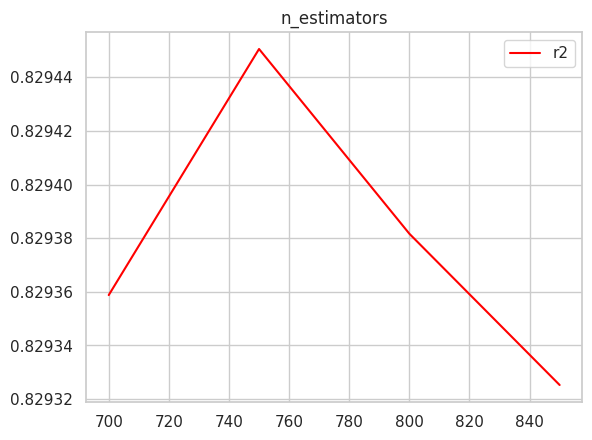

In [0]:
para = 'n_estimators'
rf = RandomForestRegressor(random_state=1)
plot_learning_curve(rf, para, start=700, end=900, step=50)

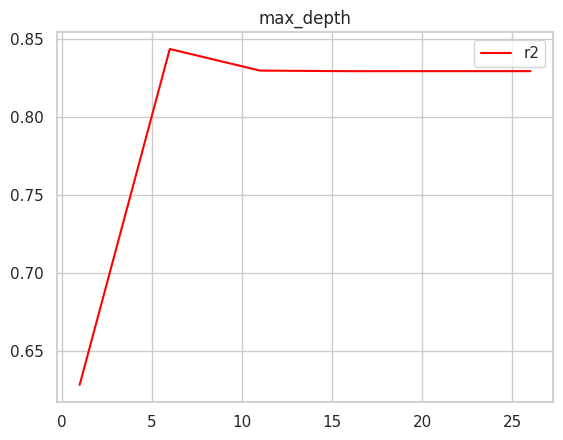

In [0]:
para = 'max_depth'
rf = RandomForestRegressor(n_estimators=750
                           ,random_state=1)
plot_learning_curve(rf, para, start=1, end=30, step=5)

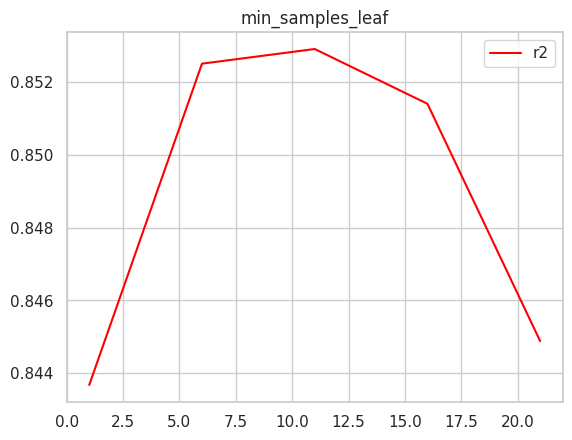

In [0]:
para = 'min_samples_leaf'
rf = RandomForestRegressor(n_estimators=750
                           ,max_depth=6
                           ,random_state=1)
plot_learning_curve(rf, para, start=1, end=26, step=5, cv=3)

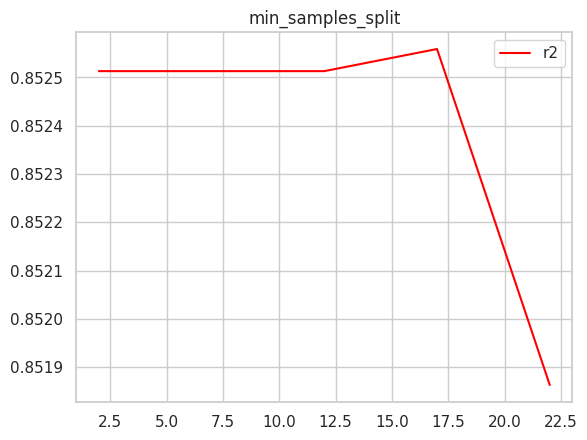

In [0]:
para = 'min_samples_split'
rf = RandomForestRegressor(min_samples_leaf=6
                           ,n_estimators=750
                           ,max_depth=6
                           ,random_state=1)
plot_learning_curve(rf, para, start=2, end=26, step=5, cv=3)

In [0]:
param_grid = {
    'n_estimators': list(range(745, 755, 1)),
    'max_depth': [5, 6, 7],
    'min_samples_split': [5, 6, 7],
    'min_samples_leaf': [15, 16, 17]
}

rf = RandomForestRegressor(random_state=1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

results = results.sort_values(by='mean_test_score', ascending=False).round(4)

results.head(3).display()

params,mean_test_score,std_test_score,rank_test_score
"List(5, 15, 5, 754)",0.8521,0.0069,1
"List(5, 15, 6, 754)",0.8521,0.0069,1
"List(5, 15, 7, 754)",0.8521,0.0069,1


In [0]:
rf = RandomForestRegressor( n_estimators=754
                           ,max_depth=5
                           ,min_samples_leaf=15
                           ,min_samples_split=5
                           ,random_state=1)
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, predictions_rf).round(2)
rmse_rf = np.sqrt(mse_rf).round(2)
r2_rf = r2_score(y_test, predictions_rf).round(4)
print(f'Test Restul - R2: {r2_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}')

Test Restul - R2: 0.8594, MSE: 19923240.62, RMSE: 4463.55


# 4.Explain The Model 

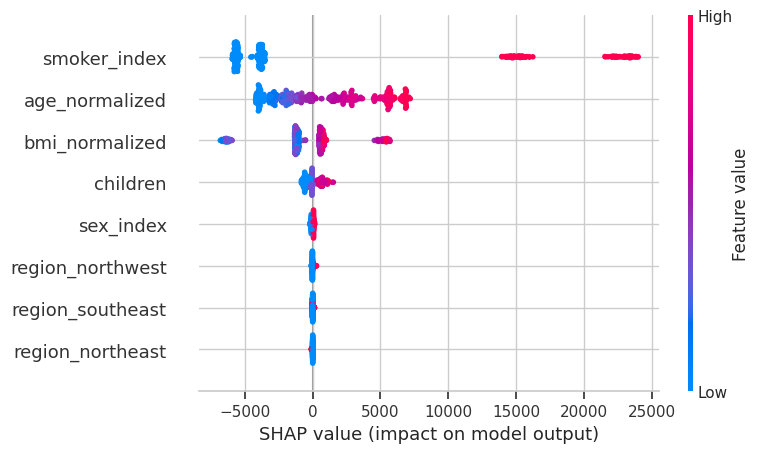

In [0]:
feature_names = ["sex_index", "smoker_index", 'region_southeast','region_northwest','region_northeast', "bmi_normalized", "age_normalized", "children"]
show_shap_summary(rf, X_train, X_test, feature_names)

In [0]:
shap.initjs()
sample_idx = 1    
show_shap_sample(X_train, X_test,feature_names,sample_idx)

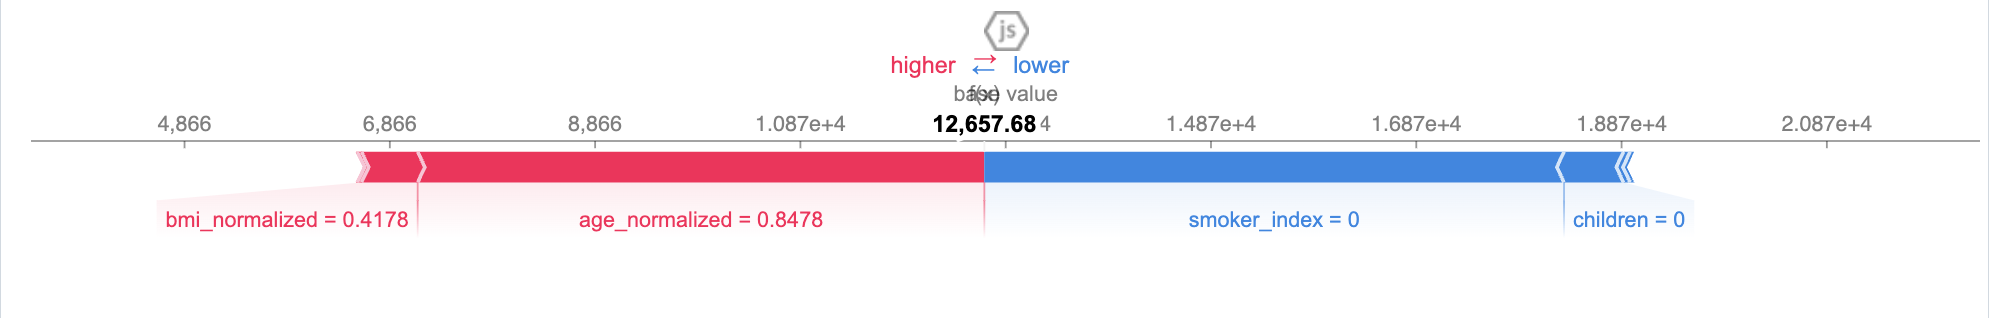

In [0]:
# from PIL import Image
# url = '/Workspace/Users/hejiekun@hotmail.com/Screenshot 2025-02-18 at 09.47.56.png'
# img = Image.open(url)
# display(img)

# 5.Model Application

In [0]:
# MLlib Model
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    labelCol="expenses",  
    featuresCol="features",
    numTrees=754,
    maxDepth=5,
    minInstancesPerNode=15,
    minInfoGain=5,
    seed=1
)

# Create Pipeline
sex_indexer = StringIndexer(inputCol="sex", outputCol="sex_index")
smoker_indexer = StringIndexer(inputCol="smoker", outputCol="smoker_index")
region_indexer = StringIndexer(inputCol="region", outputCol="region_index")
region_encoder = OneHotEncoder(inputCol="region_index", outputCol="region_encoded")

bmi_assembler = VectorAssembler(inputCols=["bmi"], outputCol="bmi_assembled")
age_assembler = VectorAssembler(inputCols=["age"], outputCol="age_assembled")
bmi_scaler = MinMaxScaler(inputCol="bmi_assembled", outputCol="bmi_normalized")
age_scaler = MinMaxScaler(inputCol="age_assembled", outputCol="age_normalized")

vector_assembler = VectorAssembler(inputCols=["sex_index", "smoker_index", "region_encoded", "bmi_normalized", "age_normalized", "children"], outputCol="features")


pipeline_rf_application = Pipeline(stages=[
    sex_indexer, smoker_indexer, region_indexer, region_encoder,   
    bmi_assembler, bmi_scaler,   
    age_assembler, age_scaler,   
    vector_assembler,
    rf
])

# Fit the pipeline to the training data
model = pipeline_rf_application.fit(df_sp)

# Save the pipeline model to disk
path_saved = "/Workspace/Users/hejiekun@hotmail.com/pipeline_rf_application2"
model.save(path_saved)

In [0]:
# Input the new claim to predictexpected expenses
age = int(input("Enter age: "))
sex = input("Enter sex: ")
bmi = float(input("Enter BMI: "))
children = int(input("Enter number of children: "))
smoker = input("Enter smoker status (yes/no): ")
region = input("Enter region: ")
actual_expenses = float(input("Enter expenses: "))
application_predict_expenses(path_saved, age, sex, bmi, children, smoker, region, actual_expenses)

# application_predict_expenses(path_saved, 25, "male", 22.0, 0, "no", "southwest", 16884.92)

Enter age:  25

Enter sex:  male

Enter BMI:  22

Enter number of children:  0

Enter smoker status (yes/no):  no

Enter region:  southwest

Enter expenses:  16884.92

Claim_Status,Expected_Expenses,Actual_Expenses
Abnormal Claim,4879.35,16884.92
